# Big Project: Fantasy Premier League (FPL) Points Predictor
## Data Rules Everything Around Me (DREAM) TEAM - Fall 2024 - CME 538
## Feras Abdulla - Maha Fakhroo - Syed Shahid Hossaini - Eric Guan
-----------------------------------------------------------------------------------------------------------------------------------------------
# ML Random Forest Points Predictor
-----------------------------------------------------------------------------------------------------------------------------------------------

### Import Packages
Imports essential Python libraries and machine learning tools for data analysis, visualization, and model evaluation, as well as functions for splitting data into training and testing sets. These are typically used in machine learning projects to build and assess predictive models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import ast

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

## Import Data
Let's start by importing the training and testing data.

In [2]:
master_cleaned = pd.read_csv('../master_cleaned.csv')
master_cleaned.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,apm,cumulative_goals,cumulative_assists,cumulative_xG,cumulative_xA,cumulative_xGI,cumulative_gpm,cumulative_apm,cumulative_xP,cumulative_points
0,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,78,...,0.000000,0,0,0.392763,0.000000,0.392763,0.000000,0.000000,0.5,1
1,Aaron Connolly,FWD,Brighton,4.0,0,2,27,1,11.3,78,...,0.000000,1,0,0.554273,0.016604,0.570877,0.007463,0.000000,4.5,9
2,Aaron Connolly,FWD,Brighton,2.7,0,0,2,0,12.1,78,...,0.000000,1,0,0.586928,0.057287,0.644215,0.004831,0.000000,7.2,11
3,Aaron Connolly,FWD,Brighton,2.7,0,0,7,0,0.3,78,...,0.000000,1,0,0.586928,0.057287,0.644215,0.003676,0.000000,9.9,13
4,Aaron Connolly,FWD,Brighton,3.0,1,0,13,0,10.3,78,...,0.083333,1,1,0.586928,0.109529,0.696457,0.003521,0.003521,12.9,17


# Feature Engineering
Once we've acquired a comprehensive understanding of the dataset, we can proceed with feature engineering.

Feature engineering is a pivotal stage in the machine learning process, as the quality and relevance of the features can exert a profound influence on the model's performance and its ability to provide accurate predictions or classifications. This endeavor combines the art of creativity, domain expertise, and the science of leveraging a deep comprehension of both the data and the specific problem at hand.

Feature engineering is one place your can set yourself apart from your classmates but for the purpose of creating a sample submission, I'll pick some of the simplest features to train the model on. Remember that for this competition, your model can use a maximum number of features specified in the contest documents!

After many iterations, 12 features were chosen to train my ML model:

Original Features:

1) `'Temperature'`
2) `'Humidity'`

Extracted Time Element Features:

3) `'Hour'`
4) `'DayOfWeek'`
5) `'Weekend'`
6) `'WeekOfYear'`

Transformed Features:

7) Square Root of `'unix_time'`
8) Sine transformation of `'Hour'`
9) Cosine transformation of `'Hour'`

Feature Interactions:

10) Product of `'Hour'` and `'DayOfWeek'`
11) Product of `'Hour'` and `'Temperature'`
12) Product of `'Weather_encoded'` and `'Hour'`

In [3]:
def feature_engineering(data):
    
    # Define Features
    data['goals_assists'] = data['goals_scored'] * data['assists']
    data['bps_goals'] = data['bps'] * data['goals_scored']
    
    feature_selected = [#'expected_goals', 
                        #'team_label', 
                        #'Influence_Creativity_Threat_Index',
                        'goals_scored',
                        'assists',
                        #'goals_assists',
                        'bps', 
                        'xP', 
                        'bonus',
                        #'team_h_score',
                        'influence',
                        'creativity',
                        #'threat',
                        'bps_goals',
                        'clean_sheets'] 

    selected_data = data[feature_selected]
    
    return selected_data

## Splitting the Data

Create a feature matrix, a label vector representing ridership, and split the data into 80 train : 20 validation

In [4]:
X = feature_engineering(master_cleaned)
y = master_cleaned['total_points']

# Split data into train+val and test sets (10% for testing)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

# Further split train+val into training and validation sets (e.g., 80-20 split of train+val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=42)


## Cross-Validation and Training the Model
Below we'll train a random forest model. Some parameters are controlled to control overfitting and improve performance, including increasing `'n_estimators'` to 1000, limiting the `'max_depth'` of the forest to 20 levels, and increasing `'min_samples_leaf'` to 2.

In [5]:
# Instantiate a classifier model
model = RandomForestRegressor(n_estimators=100, max_depth = 15, min_samples_leaf=2, min_samples_split=10, random_state=42)

Let's check out the Random Forest model hyper-parameters:

In [6]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Now let us run cross validation WITHIN the training data set to evaluate how well the model generalizes. Remember, this cross-validation occurs within the 80% of the data that has been classified as training data. There is still a 20% validation data set to check with on top of this. I added a second layer of validation here to provide an enhanced `'R2'` check.

In [7]:
# Perform cross-validation (e.g., 5-fold cross-validation)
cv_results = cross_val_score(model, X_train_val, y_train_val, cv=5, scoring='r2')  # Use appropriate scoring metric
print("Cross-validation R^2 scores:", cv_results)
print("Mean R^2 score:", cv_results.mean())

Cross-validation R^2 scores: [0.94080495 0.94108777 0.94587484 0.94378944 0.94512222]
Mean R^2 score: 0.9433358438943358


Now let's train the model.

In [8]:
# Train on the full training+validation set for final evaluation on the test set
model.fit(X_train_val, y_train_val)

RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=10,
                      random_state=42)

## Evaluate Model
Let's get the predictions on our validation dataset.

In [9]:
y_pred = model.predict(X_test)

And now, let's print out the `R2` score.

In [10]:
test_score = r2_score(y_test, y_pred)  # Calculate R² score manually
print(test_score)

0.9466536614299252


In [11]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.4624190511515763
Mean Absolute Error (MAE): 0.4819450496495079


Let's take a look at our model's feature importances.


Feature Importance:
        Feature  Importance
2           bps    0.782832
1       assists    0.049042
8  clean_sheets    0.045201
7     bps_goals    0.038370
4         bonus    0.037071
5     influence    0.014251
0  goals_scored    0.013188
6    creativity    0.012137
3            xP    0.007907


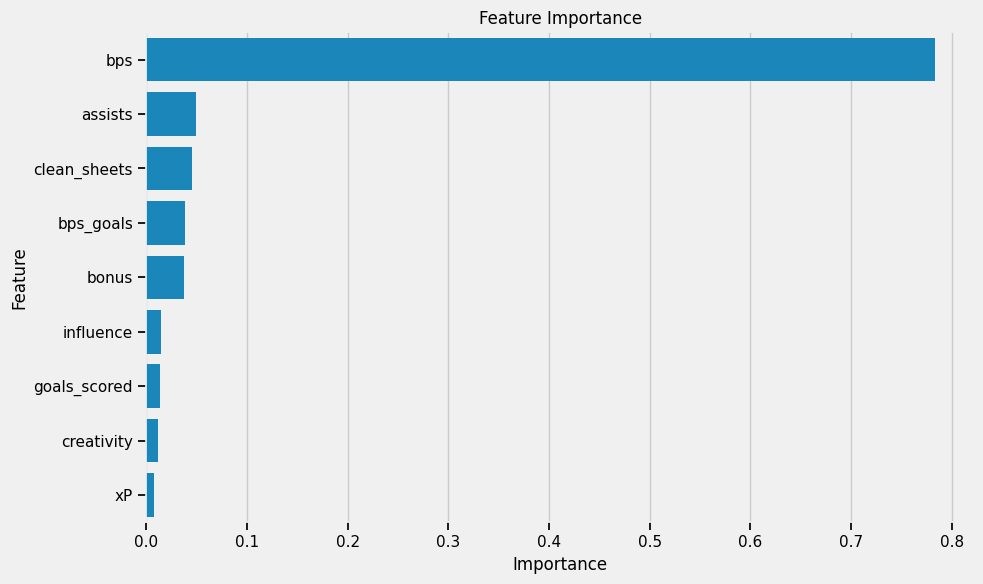

In [12]:
# Feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nFeature Importance:")
print(feature_importance_df.head(20))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

As we can see, the bonus point system `'BPS'` raw scoring metric has an outsized importance in the predictive power of this model.

Let's try training on Seasons 2020-2021 to 2023-2024, and predicting on Season 2024-2025.

In [13]:
train = master_cleaned[(master_cleaned['Season'] != '2024-2025')]
test = master_cleaned[(master_cleaned['Season'] == '2024-2025')]

X2 = feature_engineering(train)
y2 = train['total_points']

# Instantiate a classifier model
model2 = RandomForestRegressor(n_estimators=100, max_depth = 15, min_samples_leaf=2, min_samples_split=10, random_state=42)

# Perform cross-validation (e.g., 5-fold cross-validation)
cv_results2 = cross_val_score(model2, X2, y2, cv=5, scoring='r2')  # Use appropriate scoring metric
print("Cross-validation R^2 scores:", cv_results2)
print("Mean R^2 score:", cv_results2.mean())

X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, train_size=0.8, random_state=42)

# Train on the full training+validation set for final evaluation on the test set
model2.fit(X2_train, y2_train)

y_pred2 = model2.predict(X2_val)
val_r2 = r2_score(y2_val, y_pred2)

print("Validation R^2 score:", val_r2)
print("Validation Mean Squared Error (MSE):", mean_squared_error(y2_val, y_pred2))
print("Validation Mean Absolute Error (MAE):", mean_absolute_error(y2_val, y_pred2))


Cross-validation R^2 scores: [0.94696349 0.94468227 0.94268872 0.94188437 0.94176718]
Mean R^2 score: 0.9435972055032968
Validation R^2 score: 0.9438798173664034
Validation Mean Squared Error (MSE): 0.4918872412081257
Validation Mean Absolute Error (MAE): 0.49455811200751015


In [14]:
X3 = feature_engineering(test)
y3 = test['total_points']

# Retrain on full training data (train + validation) for final testing
model2.fit(X2, y2)

y_pred3 = model2.predict(X3)
test_r2 = r2_score(y3, y_pred3)

print("Test R^2 score:", test_r2)
print("Test Mean Squared Error (MSE):", mean_squared_error(y3, y_pred3))
print("Test Mean Absolute Error (MAE):", mean_absolute_error(y3, y_pred3))

Test R^2 score: 0.939691815262311
Test Mean Squared Error (MSE): 0.4949547305813381
Test Mean Absolute Error (MAE): 0.48666718023226624
